# 🕵️ Olist Business Deep Dive: Customers, Reviews & Revenue

## Objective
Go beyond simple delivery prediction to understand the **drivers of business value**.
1.  **Customer Satisfaction**: What drives 1-star reviews?
2.  **Product Strategy**: Which categories drive revenue (Pareto Principle)?
3.  **Geography**: Where is the money coming from?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Load datasets
path = "olist_data/"
orders = pd.read_csv(path + "olist_orders_dataset.csv")
reviews = pd.read_csv(path + "olist_order_reviews_dataset.csv")
items = pd.read_csv(path + "olist_order_items_dataset.csv")
products = pd.read_csv(path + "olist_products_dataset.csv")
payments = pd.read_csv(path + "olist_order_payments_dataset.csv")
customers = pd.read_csv(path + "olist_customers_dataset.csv")

print("Datasets loaded.")

Datasets loaded.


## 1. The "Un-Happy Path": Drivers of Bad Reviews ⭐
Does delivery time correlate with review scores?

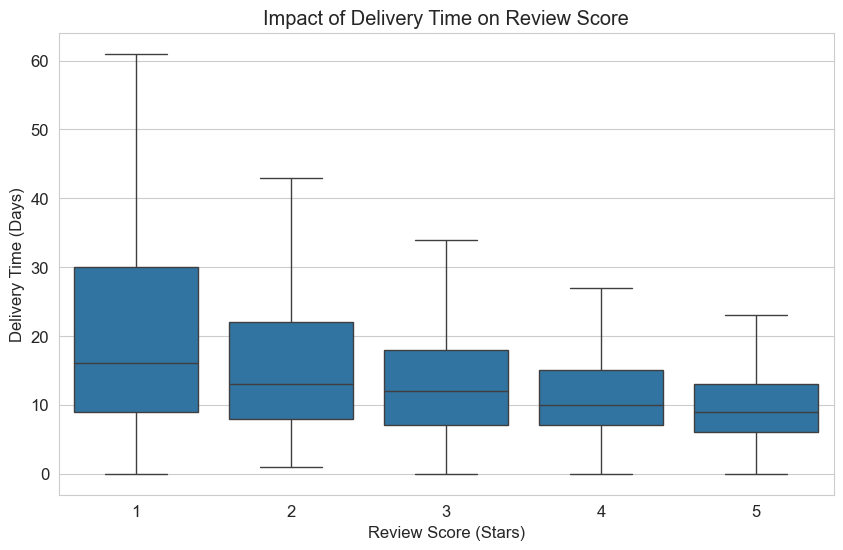

review_score
1    20.849973
2    16.194832
3    13.793242
4    11.848054
5    10.224154
Name: delivery_days, dtype: float64


In [2]:
# Merge Orders with Reviews
df_rev = orders.merge(reviews, on='order_id')

# Calculate Delivery Time
df_rev['order_delivered_customer_date'] = pd.to_datetime(df_rev['order_delivered_customer_date'])
df_rev['order_purchase_timestamp'] = pd.to_datetime(df_rev['order_purchase_timestamp'])
df_rev['delivery_days'] = (df_rev['order_delivered_customer_date'] - df_rev['order_purchase_timestamp']).dt.days

# Filter delivered only
df_rev = df_rev[df_rev['order_status'] == 'delivered'].dropna(subset=['delivery_days'])

# Boxplot: Delivery Days vs Review Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_days', data=df_rev, showfliers=False)
plt.title("Impact of Delivery Time on Review Score")
plt.xlabel("Review Score (Stars)")
plt.ylabel("Delivery Time (Days)")
plt.show()

# Print Averages
print(df_rev.groupby('review_score')['delivery_days'].mean())

### 1b. Late vs On-Time Sentiment
Quantify the penalty for being late.

In [3]:
df_rev['order_estimated_delivery_date'] = pd.to_datetime(df_rev['order_estimated_delivery_date'])
df_rev['is_late'] = df_rev['order_delivered_customer_date'] > df_rev['order_estimated_delivery_date']

avg_score_late = df_rev[df_rev['is_late']]['review_score'].mean()
avg_score_ontime = df_rev[~df_rev['is_late']]['review_score'].mean()

print(f"Avg Score (On-Time): {avg_score_ontime:.2f} ⭐")
print(f"Avg Score (Late):    {avg_score_late:.2f} ⭐")
print(f"Late Penalty:        {avg_score_late - avg_score_ontime:.2f} stars")

Avg Score (On-Time): 4.29 ⭐
Avg Score (Late):    2.57 ⭐
Late Penalty:        -1.73 stars


## 2. The Pareto Principle (80/20 Rule) 📦
Which product categories drive the most revenue?

Total Categories: 73
Categories driving 80% of revenue: 16
Pareto Ratio: 21.9% of categories drive 80% of sales.


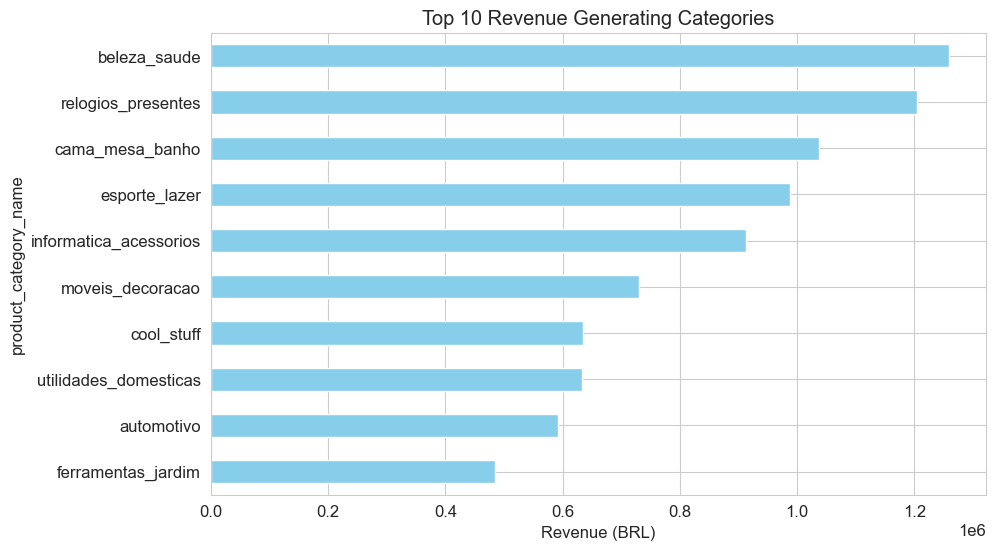

In [4]:
# Merge Items + Products + Payments (Revenue is in Payments or Items price)
# Let's use Item Price for "Sales Revenue"
df_prod = items.merge(products, on='product_id')

# Total Revenue by Category
cat_rev = df_prod.groupby('product_category_name')['price'].sum().sort_values(ascending=False)

# Cumulative Percentage
total_revenue = cat_rev.sum()
cumulative = cat_rev.cumsum() / total_revenue

top_20_percent_cats = cumulative[cumulative <= 0.8].count()
total_cats = len(cat_rev)

print(f"Total Categories: {total_cats}")
print(f"Categories driving 80% of revenue: {top_20_percent_cats}")
print(f"Pareto Ratio: {top_20_percent_cats/total_cats*100:.1f}% of categories drive 80% of sales.")

# Plot Top 10
plt.figure(figsize=(10, 6))
cat_rev.head(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Revenue Generating Categories")
plt.xlabel("Revenue (BRL)")
plt.gca().invert_yaxis()
plt.show()

## 3. Geographic Heatmap (Where is the money?) 🗺️
Customer State distribution by AOV (Average Order Value).

In [5]:
# Orders + Customers + Payments
df_geo = orders.merge(customers, on='customer_id')
df_geo = df_geo.merge(payments, on='order_id')

state_metrics = df_geo.groupby('customer_state').agg(
    total_sales=('payment_value', 'sum'),
    order_count=('order_id', 'nunique')
)
state_metrics['AOV'] = state_metrics['total_sales'] / state_metrics['order_count']

state_metrics.sort_values('total_sales', ascending=False).head(10)

,total_sales,order_count,AOV
customer_state,,,
SP,5998226.96,41745,143.687315
RJ,2144379.69,12852,166.851828
MG,1872257.26,11635,160.915966
RS,890898.54,5466,162.989122
PR,811156.38,5045,160.784218
SC,623086.43,3637,171.318787
BA,616645.82,3380,182.439592
DF,355141.08,2140,165.953776
GO,350092.31,2020,173.313025
